## Advanced Data Analytics
## UE22AM343AB4
# **SARIMAX and Prophet**
- Teaching Assistant : Nischal H S

In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install statsmodels
!pip install tbats
!pip install prophet
!pip install pmdarima  # for auto ARIMA functionality

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# load the dataset
df = pd.read_csv('smart_building_energy_data.csv')

# display the first few rows of the dataset
print(df.head())

# display the dataset information
print(df.info())

# check for missing values
print(df.isnull().sum())

# check for duplicates
print(df.duplicated().sum())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Convert timestamp to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print(f"The time series is stationary (reject null hypothesis).")
    else:
        print(f"The time series is non-stationary (fail to reject null hypothesis).")

test_stationarity(df['energy_consumption'])

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['energy_consumption'], lags=50, ax=ax1)
plot_pacf(df['energy_consumption'], lags=50, ax=ax2)
plt.show()

# Use auto_arima to find optimal parameters with brute force
# This could be extremely slow to find the right values, your 2 hr class might get over before you run this!
# model = auto_arima(df['energy_consumption'], seasonal=True, m=24,
#                    start_p=0, start_q=0, max_p=5, max_q=5, max_d=2,
#                    start_P=0, start_Q=0, max_P=2, max_Q=2, max_D=1,
#                    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# print(model.summary())
# print(f"Suggested SARIMAX order: {model.order}")
# print(f"Suggested seasonal order: {model.seasonal_order}")

# check for seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['energy_consumption'], model='additive', period=24)

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend') #this will not give you the right trend, because we have accounted for the daily seasonality but not the other seasonality!
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# split the data into training and testing sets
train_data = df['energy_consumption'].iloc[:-(24*30)]
test_data = df['energy_consumption'].iloc[-(24*30):]

Since it is stationary, we do not have to worry about differencing etc for now.

The ACF plot shows clear seasonal patterns, with peaks occurring at regular intervals (approximately every 24 lags). This suggests a strong seasonal component with a period of 24, which is typical for hourly data over a day.

The seasonal period (m) should be set to 24, based on the clear 24-lag cycle in the ACF.

You might start with a seasonal order of (1,1,1,24), where:
P=1 (seasonal AR), D=1 (seasonal differencing), Q=1 (seasonal MA), m=24 (seasonal period)

Non-Seasonal Component:

- p (AR order): Consider starting with p=1 or p=2, as there's a gradual decay in the first few lags.

- d (differencing): Since there's a slow decay overall, you might need d=1

- q (MA order): The significant spikes in the first few lags suggest q=1 or q=2 might be appropriate.

Based on this ACF plot, a good starting point for your SARIMAX model could be:
SARIMAX(1,1,1)(1,1,1,24)

This is a starting point but you will need to experiment a little (changing AR and MA values to 0 or 2 instead of 1) for best fit.

The PACF plot gives similar inference.

For analysing the right orders to use, you can also use AIC and BIC

If you have a lot of time, you can try auto_arima

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot daily pattern
daily_pattern = df['energy_consumption'].groupby(df.index.hour).mean()
plt.figure(figsize=(12, 6))
daily_pattern.plot()
plt.title('Average Daily Energy Consumption Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption')
plt.show()

#As we saw earlier, daily is not the only seasonality, what other seasonality might energy consumption have?

# Plot yearly pattern
yearly_pattern = df['energy_consumption'].resample('M').mean()
plt.figure(figsize=(12, 6))
yearly_pattern.plot()
plt.title('Monthly Average Energy Consumption Pattern')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.show()

# You will see that energy consuption seems to be lowest around september-october
# Speaking of October, PES Innovation Lab's Roadshow is coming this month! Do check it out

# **Understanding SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)**

SARIMAX is an extension of the ARIMA model that incorporates seasonal components and exogenous variables. It's particularly useful for time series data with seasonal patterns and external factors influencing the target variable.

## Components of SARIMAX:

1. **Seasonal (S)**: Captures repeating patterns or cycles in the data.
2. **AutoRegressive (AR)**: Uses past values to predict future values.
3. **Integrated (I)**: Differencing to make the time series stationary.
4. **Moving Average (MA)**: Uses past forecast errors in the prediction.
5. **eXogenous variables (X)**: Incorporates external factors that influence the target variable.

Note: we do not use exogenous variables as part of this lab, but do explore them as it will be needed for the Kaggle Hackathon next month.

## SARIMAX Parameters:

SARIMAX(p,d,q)(P,D,Q,m)X

- p: Order of the AR term
- d: Degree of differencing
- q: Order of the MA term
- P: Seasonal order of the AR term
- D: Seasonal degree of differencing
- Q: Seasonal order of the MA term
- m: Number of periods per season
- X: Exogenous variables

SARIMAX is powerful for forecasting time series data with complex patterns, especially when external factors significantly influence the target variable.

# **Understanding Prophet**

Prophet is a forecasting tool developed by Facebook (now Meta) designed to work with time series data that display strong seasonal effects and several seasons of historical data. It's particularly useful for business forecasting tasks.

## Key Features of Prophet:

1. **Flexibility**: Handles daily, weekly, and yearly seasonality, plus holiday effects.
2. **Robustness**: Handles missing data and outliers well.
3. **Intuitive Parameters**: Easy to adjust without extensive time series analysis expertise.
4. **Fast**: Fits models in Stan, allowing for quick model fitting.

## Components of the Prophet Model:

1. **Trend**: Non-periodic changes in the time series.
2. **Seasonality**: Periodic changes (e.g., weekly, yearly).
3. **Holidays**: User-provided list of important events.
4. **Error Term**: Any idiosyncratic changes not accommodated by the model.

Prophet uses a decomposable time series model with three main components:

y(t) = g(t) + s(t) + h(t) + ε(t)

Where:
- g(t) is the trend function
- s(t) represents periodic changes (e.g., weekly, yearly seasonality)
- h(t) represents holiday effects
- ε(t) is the error term

Prophet is particularly useful when you have strong seasonal effects and several seasons of historical data- which happens to be the case for this problem- making it a good choice for many business and economic use cases.

In [ ]:
# Let's try out some time series models on this!

# SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model - this one can take a while (took me 10 minutes on colab)
sarimax_model = SARIMAX(train_data,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 24),
                        initialization='approximate_diffuse')
sarimax_results = sarimax_model.fit()

# Prophet Model
from prophet import Prophet

# Prepare data for Prophet
prophet_train = train_data.reset_index().rename(columns={'timestamp': 'ds', 'energy_consumption': 'y'})

# Create and fit the model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_train)

In [ ]:
# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=24, freq='H')
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast.tail(24*30)['yhat']  # Get only the forecasted part


# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model_name} - Mean Absolute Error: {mae:.2f}')
    print(f'{model_name} - Root Mean Squared Error: {rmse:.2f}')

# Evaluate Prophet
evaluate_model(test_data, prophet_forecast, 'Prophet')

# Evaluate SARIMAX
# Forecast
sarimax_forecast = sarimax_results.forecast(steps=24*30)
evaluate_model(test_data, sarimax_forecast, 'SARIMAX')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, prophet_forecast, label='Prophet Forecast')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast')
plt.title('Actual vs Forecasted Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

Our SARIMAX beats Meta's Prophet! Now let's try an LSTM

# **Understanding LSTMs with an illustrated example**
- Teaching Assistant : Akash Kamalesh

Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) architecture designed to address the vanishing gradient problem in traditional RNNs. LSTMs are particularly effective for processing and predicting time series data, making them ideal for tasks like natural language processing, speech recognition, and time series forecasting.

## LSTM Architecture

The LSTM architecture consists of several key components:

1. **Cell State**: The cell state acts as the memory of the network, carrying information through the sequence. It's the horizontal line running through the top of the diagram.

2. **Gates**: LSTMs have three gates that regulate the flow of information:
   - Forget Gate
   - Input Gate
   - Output Gate

3. **Hidden State**: This is the output of the LSTM cell for the current time step.

Let's dive into each component:

### 1. Forget Gate

The forget gate decides what information to discard from the cell state.

1. It takes the previous hidden state and current input.
2. Passes them through a sigmoid function.
3. Outputs a value between 0 and 1 for each number in the cell state.
4. A value closer to 0 means "forget this", while a value closer to 1 means "keep this".

### 2. Input Gate

The input gate decides what new information to store in the cell state.

1. A sigmoid layer decides which values to update.
2. A tanh layer creates a vector of new candidate values.
3. These are combined to update the state.

### 3. Cell State Update

The cell state is updated by:

1. Multiplying the old state by the forget gate output.
2. Adding the product of the input gate and new candidate values.

### 4. Output Gate

The output gate decides what the next hidden state should be.

1. A sigmoid layer decides what parts of the cell state to output.
2. The cell state is put through tanh.
3. The tanh output is multiplied by the sigmoid output to decide what information the hidden state should carry to the next step.

---

## Example: Processing a Single Input

Let's walk through how an LSTM processes a single input:

1. **Input**: The network receives the current input $x_t$ and the previous hidden state $h_{t-1}$.

2. **Forget Gate**:
   - Calculates $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$
   - Decides what to forget from the previous cell state.

3. **Input Gate**:
   - Calculates $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - Decides what new information to store.

4. **Candidate Values**:
   - Calculates $\tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$
   - Creates new candidate values.

5. **Cell State Update**:
   - Updates the cell state:
     $$C_t = f_t * C_{t-1} + i_t * \tilde{C_t}$$
   - Forgets old information and adds new information.

6. **Output Gate**:
   - Calculates $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
   - Decides what to output.

7. **Hidden State**:
   - Calculates the new hidden state:
     $$h_t = o_t * \tanh(C_t)$$
   - This becomes the output for this time step and the input for the next time step.
---

By processing inputs this way, LSTMs can learn to keep important information for long periods and discard irrelevant information, making them highly effective for sequence data. Let's get into the next steps where we will see what data we are working with!

# Data Processing for LSTM Forecasting
Here is an overview of the data processing steps that we implemented for you. Feel free to do feature engineering on your own. The LSTM we are working with considers a 2 month window period for learning and predicts the next 30 days.
1. **Data Loading and Feature Engineering**:
   - The data is loaded from a CSV file.
   - Time-based features are added: hour and day, represented as sine and cosine functions for cyclical encoding.

2. **Feature Selection**:
   - Ten features are selected for the model, including energy consumption, temperature, humidity, occupancy, weekend/holiday flags, and the time-based features.

3. **Data Normalization**:
   - StandardScaler is used to normalize the data, ensuring all features are on a similar scale.

4. **Data Splitting**:
   - The data is split into training (80%), validation (20%).
   - There is an other hold out test set which you have to make predictions for. You will be submitting them as csv files with two columns - `timestamp` and `energy_consumption`. We will evaluate the same and provide the RMSE scores you obtained for each model (single-step and multi-step)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Constants
SEQUENCE_LENGTH = 72  # 72 hours of historical data
FORECAST_HORIZON = 24  # Predict next 24 hours for multi-step

# Features
features = ['temperature', 'humidity', 'occupancy', 'is_weekend', 'is_holiday', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

def preprocess_data(df):
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    return df

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:(i + seq_length)])
    return np.array(X)

train_data = pd.read_csv('smart_building_energy_data.csv', parse_dates=['timestamp'], index_col='timestamp')
test_data = pd.read_csv('test.csv', parse_dates=['timestamp'], index_col='timestamp')

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Scale the data
scaler_features = StandardScaler()
scaler_target = StandardScaler()

train_scaled = pd.DataFrame(scaler_features.fit_transform(train_data[features]), columns=features, index=train_data.index)
test_scaled = pd.DataFrame(scaler_features.transform(test_data[features]), columns=features, index=test_data.index)

train_target_scaled = scaler_target.fit_transform(train_data[['energy_consumption']])

# Create sequences for single-step model
X_train_single = create_sequences(train_scaled.values, SEQUENCE_LENGTH)
y_train_single = train_target_scaled[SEQUENCE_LENGTH-1:]
X_test_single = create_sequences(test_scaled.values, SEQUENCE_LENGTH)

# Create sequences for multi-step model
X_train_multi = X_train_single[:-FORECAST_HORIZON+1]
y_train_multi = np.array([train_target_scaled[i:i+FORECAST_HORIZON] for i in range(SEQUENCE_LENGTH-1, len(train_target_scaled)-FORECAST_HORIZON+1)])
X_test_multi = X_test_single
X_test_single = create_sequences(np.vstack((train_scaled.values[-SEQUENCE_LENGTH+1:], test_scaled.values)), SEQUENCE_LENGTH)

# Single-Step LSTM Model

The single-step LSTM model is designed to predict one step ahead in the time series. Here's an explanation of the model architecture and training process:

1. **Model Architecture**:
   - The model should consist of LSTM cells and Dense Layers. You can experiment with attention mechanisms etc. if you wish to but it is not required. Coding the model is your task!

2. **Model Compilation**:
   - The model should use the Adam optimizer and Mean Squared Error (MSE) as the loss function.

3. **Training**:
   - Train your model using the custom generator.

4. **Prediction and Evaluation**:
   - Predictions are made on the test set.
   - The predictions are then inverse transformed to the original scale.
   - Root Mean Squared Error (RMSE) will be used to evaluate the model's performance.


This single-step model is designed to predict the energy consumption for the next time step based on the previous 72 time steps (hours) of data. It's a simpler approach compared to the multi-step model, focusing on immediate future predictions.

Here is a plot that shows us some information about the relationships that exist in our data (before transformation):
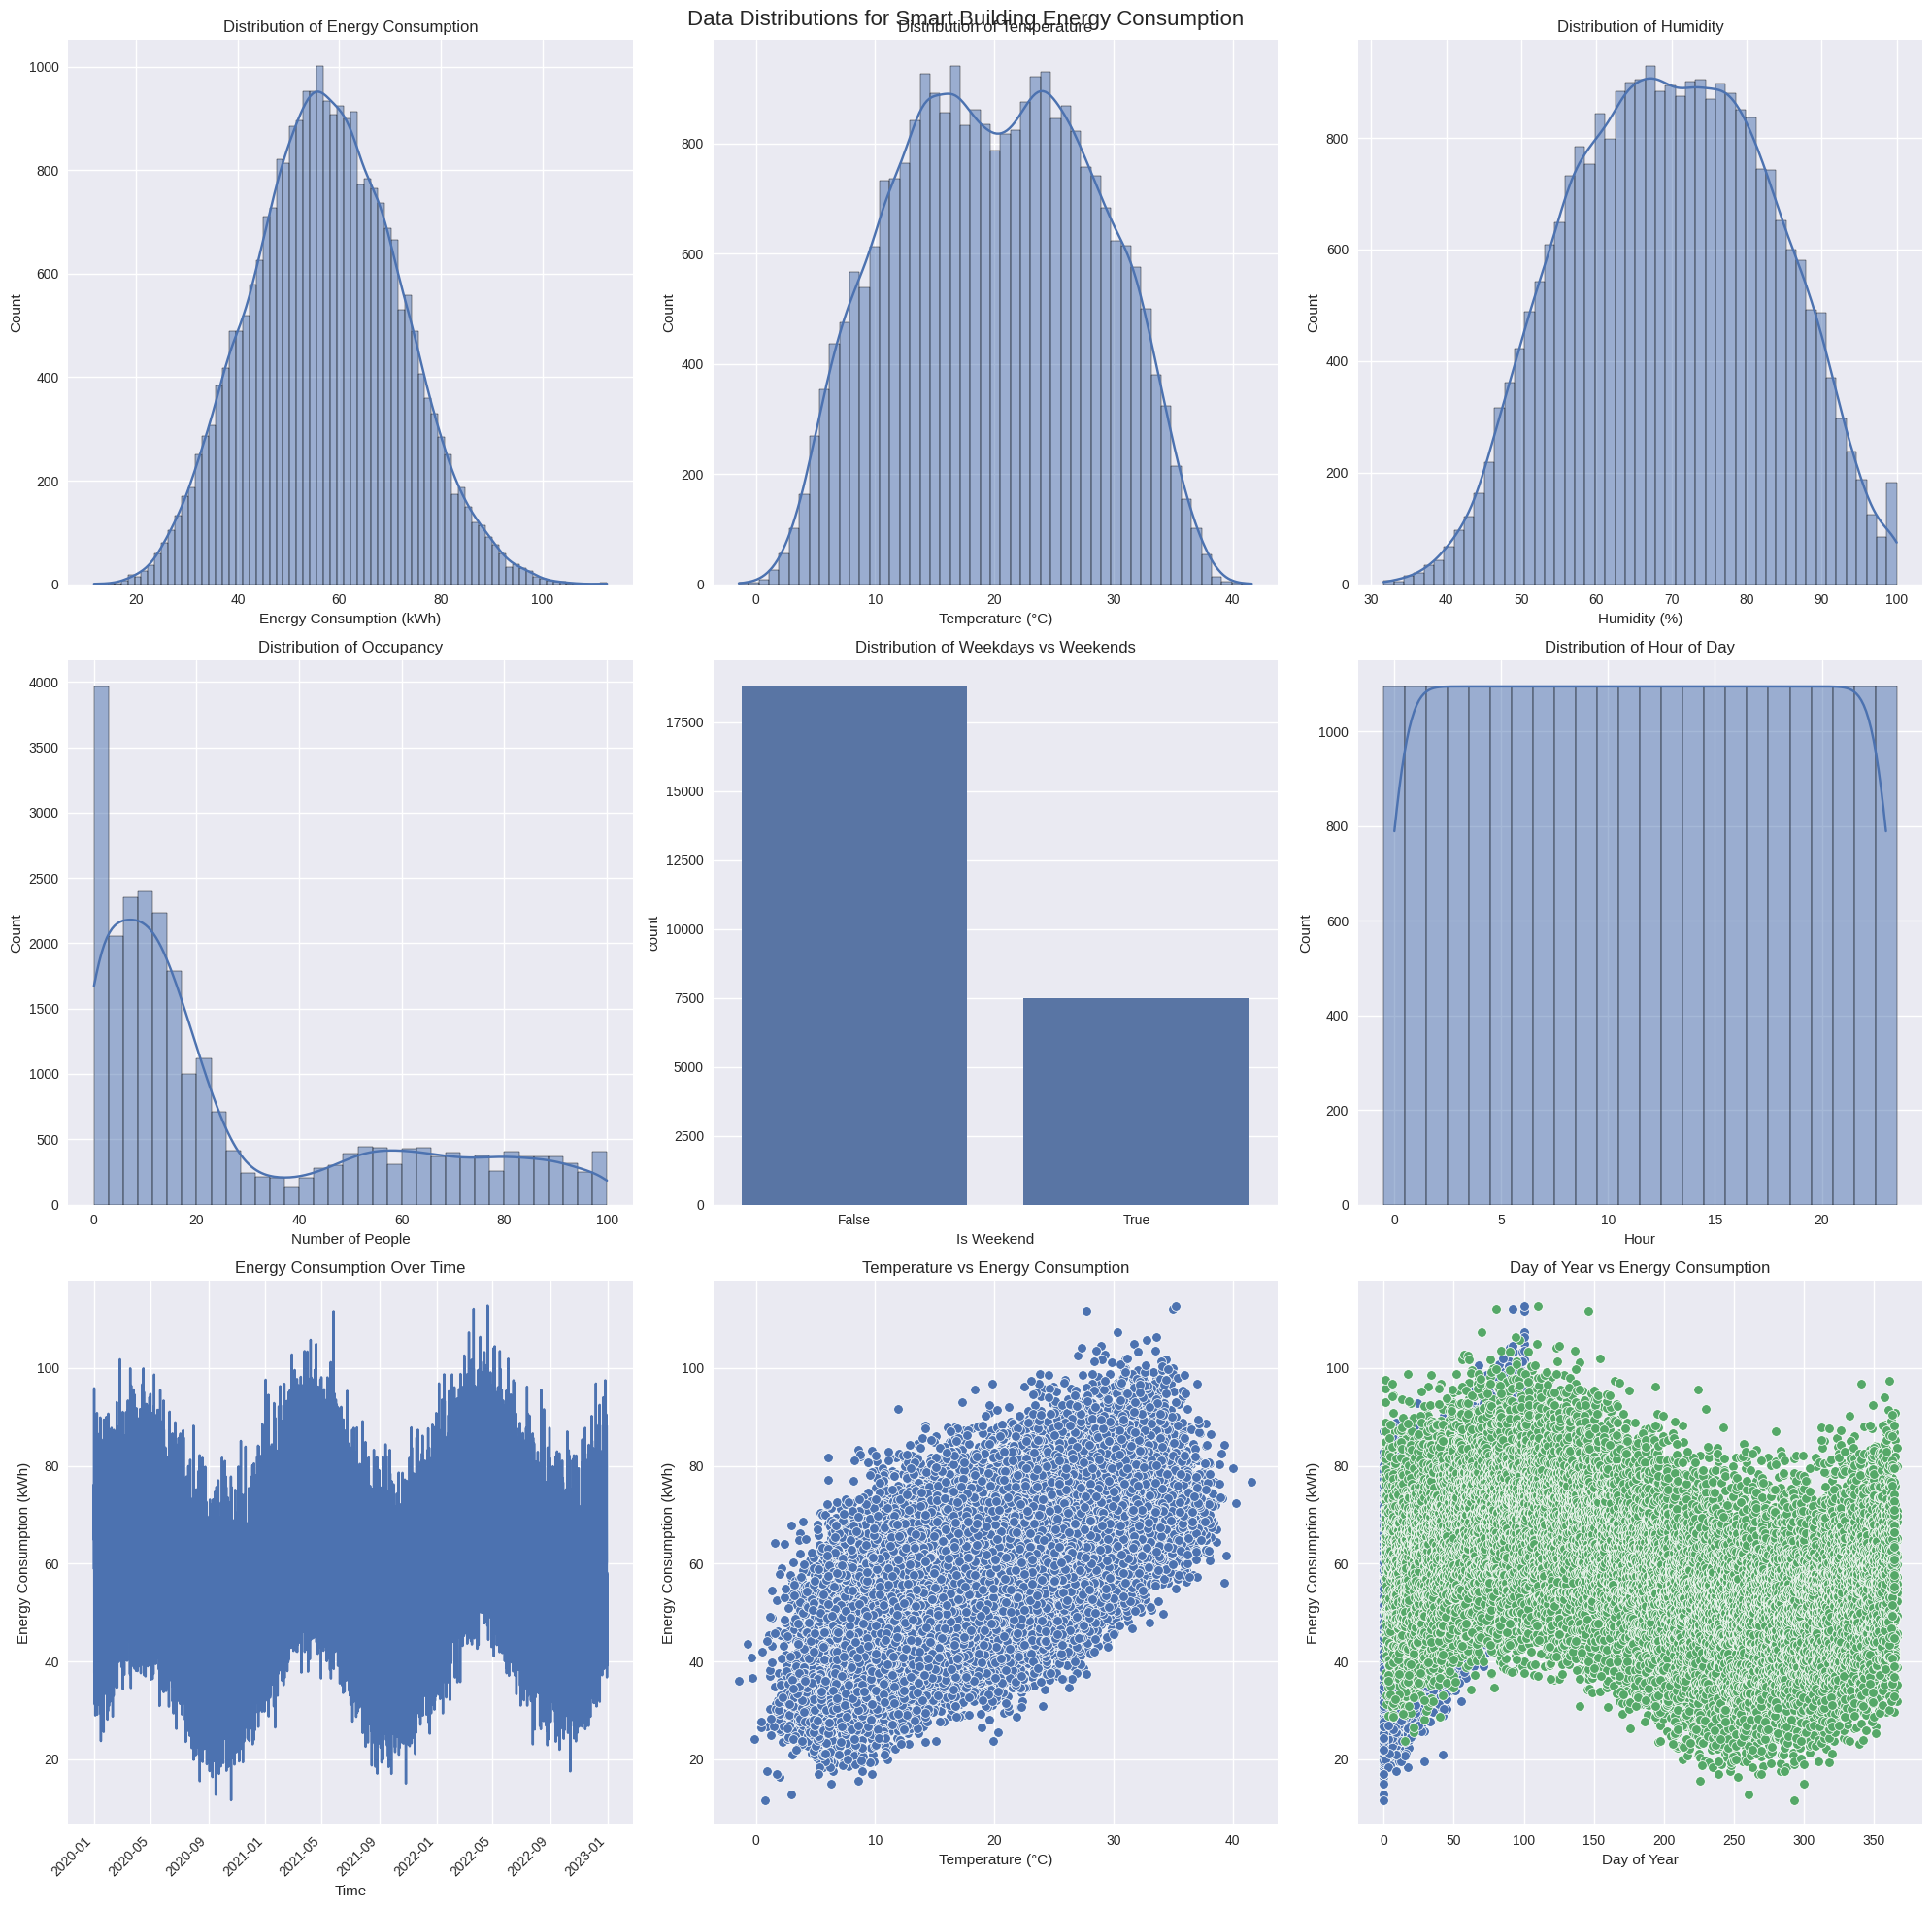

In [ ]:
# Single-step model
### TODO
single_step_model = pass
single_step_model.compile(optimizer='adam', loss='mse')
single_step_model.fit(X_train_single, y_train_single, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Multi-Step LSTM Model

The multi-step LSTM model is designed to predict multiple steps ahead in the time series. Here's an explanation of this more complex model:

1. **Model Architecture**:
   - (hint) Similar to the single-step model, but with a key difference in the output layer.

2. **Model Compilation**:
   - Should use the Adam optimizer and Mean Squared Error (MSE) as the loss function.

3. **Training**:
   - Train your model using the custom generator.

4. **Prediction and Evaluation**:
   - Predictions are made on the test set, resulting in a 30-day forecast for each input sequence.
   - The predictions are inverse transformed to the original scale.
   - RMSE is calculated to evaluate the model's performance across all predicted time steps.

5. **Visualization**:
   - The actual vs predicted values for the first sample in the test set are plotted, showing the 30-day forecast.

The key difference between the single-step and multi-step models is in their output:
- The single-step model predicts only the next time step.
- The multi-step model predicts the next 24 time steps at once.

This multi-step approach allows for longer-term forecasting but can be more challenging to train effectively due to the increased complexity of predicting further into the future.

In [ ]:
# Multi-step model
### TODO
multi_step_model = pass
multi_step_model.compile(optimizer='adam', loss='mse')
multi_step_model.fit(X_train_multi, y_train_multi, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
# Make predictions
single_step_pred_scaled = single_step_model.predict(X_test_single)
multi_step_pred_scaled = multi_step_model.predict(X_test_multi)

# Inverse transform predictions
single_step_pred = scaler_target.inverse_transform(single_step_pred_scaled)
multi_step_pred = scaler_target.inverse_transform(multi_step_pred_scaled.reshape(-1, 1)).reshape(-1, FORECAST_HORIZON)

In [ ]:
# Create DataFrames for predictions
single_step_df = pd.DataFrame({
    'timestamp': test_data.index,
    'predicted_energy_consumption': single_step_pred.flatten()
})

multi_step_df = pd.DataFrame(columns=['timestamp', 'predicted_energy_consumption'])
for i, pred in enumerate(multi_step_pred):
    timestamps = pd.date_range(start=test_data.index[i+SEQUENCE_LENGTH-1], periods=FORECAST_HORIZON, freq='H')
    temp_df = pd.DataFrame({
        'timestamp': timestamps,
        'predicted_energy_consumption': pred
    })
    multi_step_df = pd.concat([multi_step_df, temp_df])

multi_step_df = multi_step_df.drop_duplicates(subset='timestamp', keep='first').sort_values('timestamp')

# Save predictions to CSV for submission
single_step_df.to_csv('single_step_predictions.csv', index=False)
multi_step_df.to_csv('multi_step_predictions.csv', index=False)

In [ ]:
# Plot overall results
plt.figure(figsize=(15, 6))
plt.plot(single_step_df['timestamp'], single_step_df['predicted_energy_consumption'], label='Single-step Prediction')
plt.plot(multi_step_df['timestamp'], multi_step_df['predicted_energy_consumption'], label='Multi-step Prediction')
plt.title('Energy Consumption Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Energy Consumption')
plt.legend()
plt.show()

# Plot day-by-day predictions
num_days = 30 # we forecast for the first 30 days of december
start_date = test_data.index[0]  # we start predicting from 2022-12-01 which is the first entry in the test set.

for i in range(num_days):
    plt.figure(figsize=(14, 6))

    day_start = start_date + pd.Timedelta(days=i)
    day_timestamps = pd.date_range(start=day_start, periods=FORECAST_HORIZON, freq='H')

    plt.plot(day_timestamps, multi_step_pred[i], label='Multi-step Predictions', color='red', linewidth=1)

    single_step_day = single_step_df[single_step_df['timestamp'].dt.date == day_start.date()]
    plt.plot(single_step_day['timestamp'], single_step_day['predicted_energy_consumption'],
             label='Single-step Predictions', color='blue', linewidth=1)

    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Energy Consumption')
    plt.title(f'Day {i+1}: Predicted Energy Consumption ({day_start.date()})')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Submission Files
You have to submit both the single step and the multi step model's predictions as separate CSV files. you can verify the same below. The csv files should have only 2 columns:
1) timestamp - Should start from 1st December 2022 and proceed till 30th December 2022
2) energy_consumption - The forecasted values for each hour of each day in December 2022.
3) there should be a total of 720 rows (excluding the column headers)

In [ ]:
import pandas as pd
single_preds = pd.read_csv("single_step_predictions.csv")
multi_preds = pd.read_csv("multi_step_predictions.csv")
single_preds.head()

Some references for you:
1) Recurrent Neural Networks - https://www.youtube.com/watch?v=AsNTP8Kwu80
2) Long Short-Term Memory (LSTM) - https://www.youtube.com/watch?v=YCzL96nL7j0
3) A good write-up to visualize how the LSTM works - https://towardsdatascience.com/visualising-lstm-activations-in-keras-b50206da96ff#:~:text=Our%20aim%20is%20to%20visualise%20outputs%20of%20second%20LSTM%20layer
4) A good write-up about the LSTM - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
5) Our Slides 🗿